In [15]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [16]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [17]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


In [18]:
# Create a returns column using the percentage change of the settle price
yen_futures['returns'] = yen_futures["Settle"].pct_change() * 100
yen_futures['returns'] = yen_futures['returns'].replace(-np.inf, np.nan).dropna()
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,returns
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


In [19]:
# Create a lagged return column
yen_futures['lagged return'] = yen_futures['returns'].shift()
yen_futures.loc["2019-10-09": "2019-10-15"]

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,returns,lagged return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


In [20]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017'].dropna()
test = yen_futures['2018':].dropna()

# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
x_train = train['lagged return'].to_frame()
y_train = train['returns'].to_frame()
x_test = test['lagged return'].to_frame()
y_test = test['returns'].to_frame()


In [21]:
# Create a Linear Regression model and fit it to the training data
model =  LinearRegression()
x_train = np.array(x_train).reshape(-1, 1)
model.fit(x_train, y_train)

LinearRegression()

In [22]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(x_test)

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [23]:
# Assemble actual y data (Y_test) with predicted y data into two columns in a dataframe:
y_test["Predicted Return"] = predictions
y_test

,returns,Predicted Return
Date,,
2018-01-02,0.297285,-0.009599
2018-01-03,-0.240479,-0.010033
2018-01-04,-0.213028,-0.006807
2018-01-05,-0.353933,-0.006971
2018-01-08,0.062017,-0.006126
...,...,...
2019-10-09,-0.410601,-0.009275
2019-10-10,-0.369458,-0.005786
2019-10-11,-0.564304,-0.006033


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

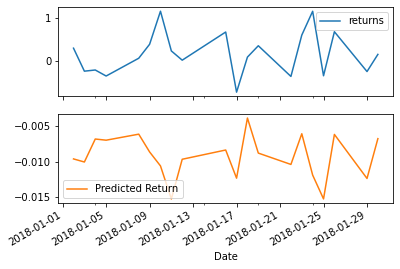

In [24]:
# Plot the first 20 predictions vs the true values
y_test.head(20).plot(subplots=True)

In [25]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    y_test["returns"],
    y_test["Predicted Return"]
)

# calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.41545437184712763


In [26]:
# Add a column of "in-sample" predictions to y_train dataframe:  
y_train["in_sample_predictions"] = model.predict(x_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
mse = mean_squared_error(
    y_train["returns"],
    y_train["in_sample_predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
rmse = np.sqrt(mse)
print(f"in-Sample Root Mean Squared Error (RMSE): {rmse}")

in-Sample Root Mean Squared Error (RMSE): 0.5962037920929946


# Conclusion

 After evaluating the results, I have determined that the model needs more information for better accuracy. 
 The error in the out-of-sample data is considerably high at .42 percent and the in-sample data has greater error at .60 percent.
 I do not feel confident in the model as-is and believe more data is needed for better accuracy.